# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_os',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=105.60863646970049, mobile=True), User(purchased=False, time_on_site=117.66246068044764, mobile=True), User(purchased=True, time_on_site=353.21187674617374, mobile=False), User(purchased=False, time_on_site=356.5670496197425, mobile=False), User(purchased=False, time_on_site=37.40564840848437, mobile=True), User(purchased=False, time_on_site=116.1732546736651, mobile=True), User(purchased=False, time_on_site=107.29554720555878, mobile=True), User(purchased=False, time_on_site=18.20924056351294, mobile=False), User(purchased=False, time_on_site=265.18578359407337, mobile=True), User(purchased=False, time_on_site=64.9256651521845, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,105.608636,True
1,False,117.662461,True
2,True,353.211877,False
3,False,356.567050,False
4,False,37.405648,True


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.234655,5.533004,7.351618,8.343854,8.679401,8.842077,9.192402,9.503654,9.702003,10.012970,...,577.407133,579.095613,579.187264,582.367029,583.300615,588.408123,589.139264,592.905392,593.394365,594.022743
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,0,1,1,0,1,...,1,1,1,1,1,0,1,0,0,1
True,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,1,0


In [6]:
pd.__version__

'1.1.0'

In [7]:
conda update pandas

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.0
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [8]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.646, 122.992]","(122.992, 240.75]","(240.75, 358.508]","(358.508, 476.265]","(476.265, 594.023]"
purchased,,,,,
False,221,208,108,31,27
True,120,149,88,20,28


In [9]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.646, 122.992]","(122.992, 240.75]","(240.75, 358.508]","(358.508, 476.265]","(476.265, 594.023]"
purchased,,,,,
False,0.648094,0.582633,0.55102,0.607843,0.490909
True,0.351906,0.417367,0.44898,0.392157,0.509091


In [10]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.696,0.561333
True,0.304,0.438667


In [11]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

In [12]:
pd.crosstab?

In [13]:
pd.crosstab(user_data['purchased'], [time_bins, user_data['mobile']])

time_on_site (4.646, 122.992]         (122.992, 240.75]         \
mobile                    False True               False True    
purchased                                                        
False                        38   183                 44   164   
True                          2   118                 14   135   

time_on_site (240.75, 358.508]        (358.508, 476.265] (476.265, 594.023]  
mobile                    False True               False              False  
purchased                                                                    
False                        34    74                 31                 27  
True                         12    76                 20                 28

In [14]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.646, 122.992]    0.218391  0.434679  0.026316  0.358663
(122.992, 240.75]   0.252874  0.389549  0.184211  0.410334
(240.75, 358.508]   0.195402  0.175772  0.157895  0.231003
(358.508, 476.265]  0.178161  0.000000  0.263158  0.000000
(476.265, 594.023]  0.155172  0.000000  0.368421  0.000000

In [15]:
ct_subset = ct.iloc[:, [2,3]]
ct_subset

purchased               True          
mobile                 False     True 
time_on_site                          
(4.646, 122.992]    0.026316  0.358663
(122.992, 240.75]   0.184211  0.410334
(240.75, 358.508]   0.157895  0.231003
(358.508, 476.265]  0.263158  0.000000
(476.265, 594.023]  0.368421  0.000000

/Applications/anaconda3/envs/Unit_2_Linear_Models/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


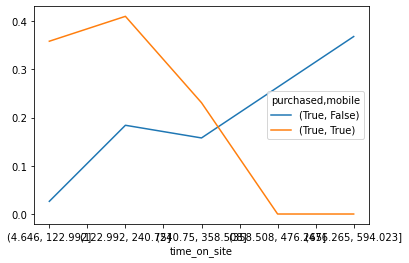

In [16]:
ct_subset.plot();

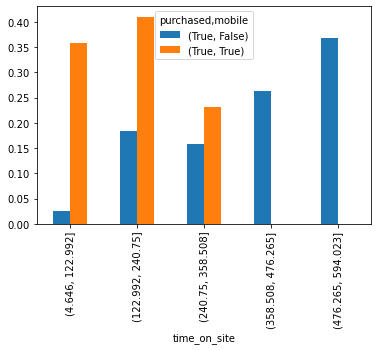

In [17]:
ct_subset.plot(kind='bar');

### MTL Bikepath dataset

In [18]:
# https://nbviewer.jupyter.org/github/jvns/pandas-cookbook/tree/master/cookbook/

In [19]:
bike_data_url = "https://raw.githubusercontent.com/jvns/pandas-cookbook/master/data/bikes.csv"

In [20]:
df = pd.read_csv(bike_data_url, sep=';', encoding='latin1', parse_dates=['Date'], dayfirst=True, index_col='Date')
df.head()

,Berri 1,Brébeuf (données non disponibles),Côte-Sainte-Catherine,Maisonneuve 1,Maisonneuve 2,du Parc,Pierre-Dupuy,Rachel1,St-Urbain (données non disponibles)
Date,,,,,,,,,
2012-01-01,35,NaN,0,38,51,26,10,16,NaN
2012-01-02,83,NaN,1,68,153,53,6,43,NaN
2012-01-03,135,NaN,2,104,248,89,3,58,NaN
2012-01-04,144,NaN,1,116,318,111,8,61,NaN
2012-01-05,197,NaN,2,124,330,97,13,95,NaN


In [21]:
pip install unidecode

Note: you may need to restart the kernel to use updated packages.


In [22]:
import unidecode

new_cols = [unidecode.unidecode(col).lower() for col in df.columns]
new_cols

['berri 1',
 'brebeuf (donnees non disponibles)',
 'cote-sainte-catherine',
 'maisonneuve 1',
 'maisonneuve 2',
 'du parc',
 'pierre-dupuy',
 'rachel1',
 'st-urbain (donnees non disponibles)']

In [23]:
df.columns = new_cols
df.head()

,berri 1,brebeuf (donnees non disponibles),cote-sainte-catherine,maisonneuve 1,maisonneuve 2,du parc,pierre-dupuy,rachel1,st-urbain (donnees non disponibles)
Date,,,,,,,,,
2012-01-01,35,NaN,0,38,51,26,10,16,NaN
2012-01-02,83,NaN,1,68,153,53,6,43,NaN
2012-01-03,135,NaN,2,104,248,89,3,58,NaN
2012-01-04,144,NaN,1,116,318,111,8,61,NaN
2012-01-05,197,NaN,2,124,330,97,13,95,NaN


In [24]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

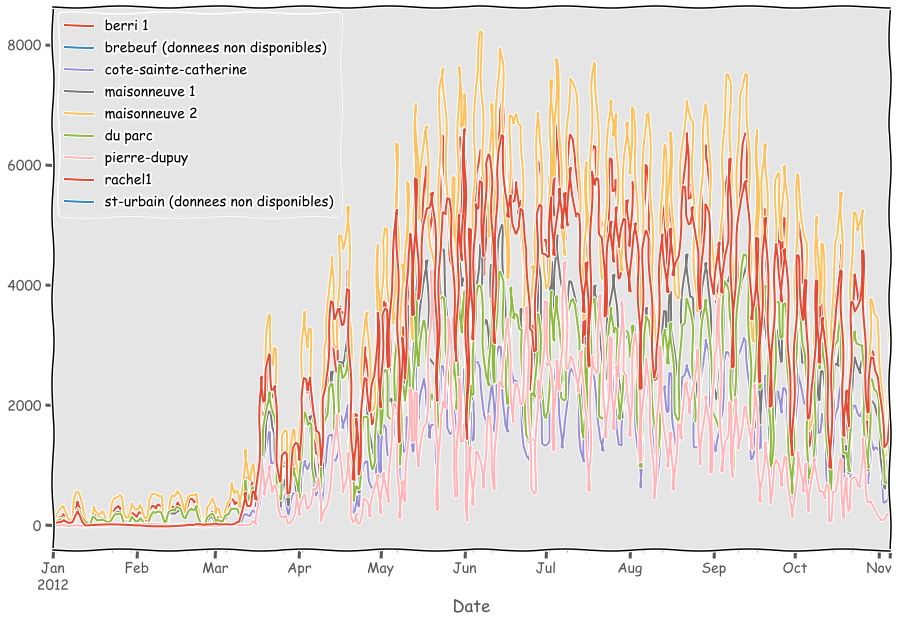

In [25]:
with plt.xkcd():
    df.plot(figsize=(15,10))

In [26]:
cols = ['pierre-dupuy', 'berri 1']   # !!!!!!!!!!! col = 'berri 1' - for one colum. We can try different biker, or several bikers
bike_path = df[cols]#.copy()    # Make a copy only when you need one! It takes space on your MAC

In [27]:
bike_path

,pierre-dupuy,berri 1
Date,,
2012-01-01,10,35
2012-01-02,6,83
2012-01-03,3,135
2012-01-04,8,144
2012-01-05,13,197
...,...,...
2012-11-01,165,2405
2012-11-02,97,1582
2012-11-03,105,844


In [28]:
bike_path.index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2012-10-27', '2012-10-28', '2012-10-29', '2012-10-30',
               '2012-10-31', '2012-11-01', '2012-11-02', '2012-11-03',
               '2012-11-04', '2012-11-05'],
              dtype='datetime64[ns]', name='Date', length=310, freq=None)

In [29]:
bike_path.index.day

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            27, 28, 29, 30, 31,  1,  2,  3,  4,  5],
           dtype='int64', name='Date', length=310)

In [30]:
bike_path.index.weekday

Int64Index([6, 0, 1, 2, 3, 4, 5, 6, 0, 1,
            ...
            5, 6, 0, 1, 2, 3, 4, 5, 6, 0],
           dtype='int64', name='Date', length=310)

In [31]:
bike_path.loc[:, 'weekday'] = bike_path.index.weekday
bike_path.head()

/Applications/anaconda3/envs/Unit_2_Linear_Models/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Applications/anaconda3/envs/Unit_2_Linear_Models/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,pierre-dupuy,berri 1,weekday
Date,,,
2012-01-01,10,35,6
2012-01-02,6,83,0
2012-01-03,3,135,1
2012-01-04,8,144,2
2012-01-05,13,197,3


In [32]:
weekday_counts = bike_path.groupby('weekday').aggregate(sum)
weekday_counts

,pierre-dupuy,berri 1
weekday,,
0,46204,134298
1,35167,135305
2,43263,152972
3,45385,160131
4,42470,141771
5,52861,101578
6,61485,99310


In [33]:
weekday_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [34]:
weekday_counts

,pierre-dupuy,berri 1
Monday,46204,134298
Tuesday,35167,135305
Wednesday,43263,152972
Thursday,45385,160131
Friday,42470,141771
Saturday,52861,101578
Sunday,61485,99310


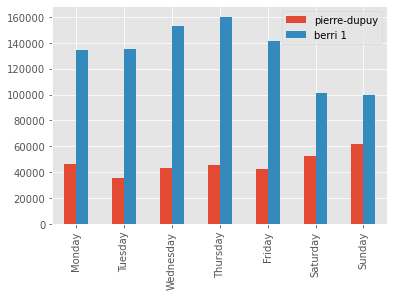

In [35]:
weekday_counts.plot(kind='bar');

In [36]:
weekday_counts['berri 1 norm'] = weekday_counts['berri 1'] / weekday_counts['berri 1'].max()
weekday_counts['pierre-dupuy norm'] = weekday_counts['pierre-dupuy'] / weekday_counts['pierre-dupuy'].max()

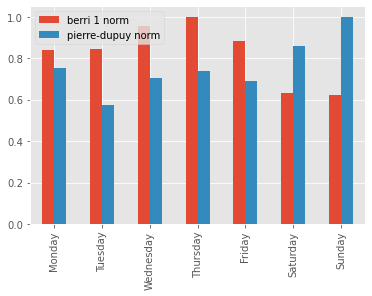

In [37]:
weekday_counts[['berri 1 norm', 'pierre-dupuy norm']].plot(kind='bar');

/Applications/anaconda3/envs/Unit_2_Linear_Models/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


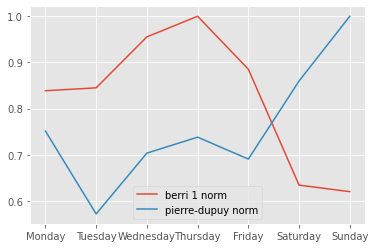

In [38]:
weekday_counts[['berri 1 norm', 'pierre-dupuy norm']].plot();

## Vancouver Crime Dataset

In [39]:
import wget
wget.download('ftp://webftp.vancouver.ca/opendata/csv/crime_csv_all_years.zip')

'crime_csv_all_years (1).zip'

In [40]:
import zipfile
with zipfile.ZipFile('crime_csv_all_years.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [41]:
df = pd.read_csv('crime_csv_all_years.csv')
df.head(10)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Residential/Other,2003,12,7,21.0,30.0,36XX E 47TH AVE,Killarney,498148.47,5452617.84
1,Break and Enter Residential/Other,2003,2,9,18.0,0.0,16XX GRANT ST,Grandview-Woodland,494890.46,5457626.75
2,Theft from Vehicle,2003,1,8,11.0,45.0,19XX W 11TH AVE,Kitsilano,489121.18,5456575.35
3,Theft from Vehicle,2003,3,20,18.0,0.0,19XX VINE ST,Kitsilano,488546.95,5457304.88
4,Theft from Vehicle,2003,2,19,17.0,30.0,19XX VINE ST,Kitsilano,488546.95,5457304.88
5,Break and Enter Residential/Other,2003,2,21,14.0,0.0,16XX GRANVILLE ST,Central Business District,490419.48,5457877.04
6,Offence Against a Person,2003,3,15,NaN,NaN,OFFSET TO PROTECT PRIVACY,NaN,0.00,0.00
7,Theft from Vehicle,2003,1,30,16.0,0.0,19XX VICTORIA DR,Grandview-Woodland,495217.31,5457218.96
8,Theft from Vehicle,2003,4,11,1.0,48.0,19XX VERNON DR,Strathcona,494267.38,5457234.70
9,Vehicle Collision or Pedestrian Struck (with I...,2003,8,23,17.0,40.0,VICTORIA DR / E 30TH AVE,Kensington-Cedar Cottage,495252.00,5454589.00


In [42]:
df.shape

(613900, 10)

In [43]:
df['TYPE'].value_counts(normalize=True)

Theft from Vehicle                                        0.334748
Mischief                                                  0.134660
Break and Enter Residential/Other                         0.107081
Other Theft                                               0.103281
Offence Against a Person                                  0.099752
Theft of Vehicle                                          0.067063
Break and Enter Commercial                                0.062434
Theft of Bicycle                                          0.049515
Vehicle Collision or Pedestrian Struck (with Injury)      0.040595
Vehicle Collision or Pedestrian Struck (with Fatality)    0.000466
Homicide                                                  0.000406
Name: TYPE, dtype: float64

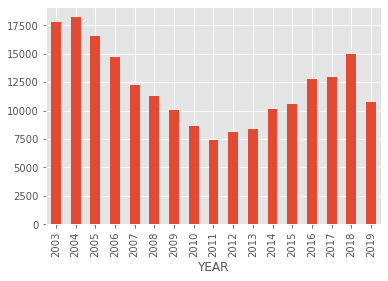

In [44]:
df[df['TYPE'] == 'Theft from Vehicle'].groupby('YEAR')['TYPE'].agg('count').plot(kind='bar');

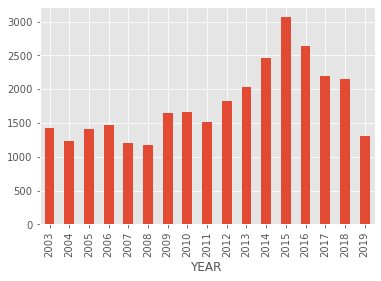

In [45]:
df[df['TYPE'] == 'Theft of Bicycle'].groupby('YEAR')['TYPE'].agg('count').plot(kind='bar');

In [46]:
def plot_crime_type_vs_year(col_name):
    df[df['TYPE'] == col_name].groupby('YEAR')['TYPE'].agg('count').plot(kind='bar')

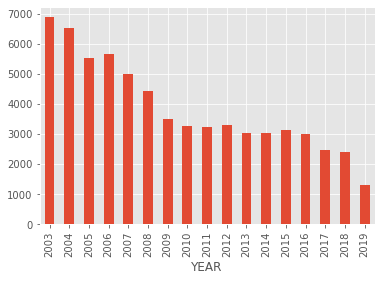

In [47]:
plot_crime_type_vs_year('Break and Enter Residential/Other')

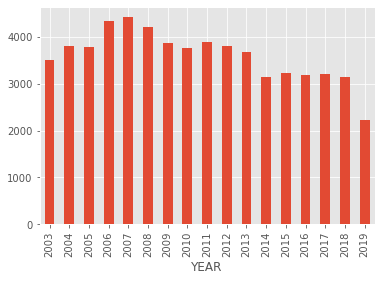

In [48]:
plot_crime_type_vs_year('Offence Against a Person')

## Plotting points on map (advanced)

In [50]:
import folium

In [59]:
pip install utm

Processing /Users/ed/Library/Caches/pip/wheels/22/85/c2/314ffed39b8e02ca623e9b7d2ad7fcf3f8544a0e77c096be76/utm-0.5.0-cp37-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [60]:
import utm

In [61]:
def utm2wgs84(row):
    try:
        return pd.Series(utm.to_latlon(row['X'], row['Y'], 10, 'U'))
    except:
        return pd.Series((None, None))

In [62]:
df_bike_theft = df[df['TYPE'] == 'Theft of Bicycle'].copy()

In [63]:
df_bike_theft.sample(5)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
316100,Theft of Bicycle,2010,11,6,5.0,0.0,14XX E 15TH AVE,Kensington-Cedar Cottage,494635.47,5455971.84
273669,Theft of Bicycle,2009,6,27,15.0,30.0,38XX ONTARIO ST,Riley Park,492367.26,5455290.27
445326,Theft of Bicycle,2015,10,27,22.0,0.0,18XX MAIN ST,Mount Pleasant,492683.65,5457361.32
393708,Theft of Bicycle,2013,6,10,0.0,1.0,GRANVILLE ST / NELSON ST,Central Business District,491050.95,5458506.95
276478,Theft of Bicycle,2009,7,19,9.0,30.0,6XX BURRARD ST,Central Business District,491279.21,5459177.42


In [64]:
df_bike_theft[['lat', 'lon']] = df_bike_theft.apply(lambda row: utm2wgs84(row), axis=1)

In [65]:
df_bike_theft[['lat', 'lon']].head()

,lat,lon
11870,49.274530,-123.112245
12192,49.281843,-123.099582
12194,49.281843,-123.099582
12197,49.281843,-123.099582
12201,49.281843,-123.099582


In [66]:
locations_list = list(zip(df_bike_theft['lat'], df_bike_theft['lon']))
len(locations_list)

30397

In [67]:
folium_map = folium.Map(location=[49.274530,  -123.112245], zoom_start=12)
for point in locations_list[:20]:
    folium.Marker(point).add_to(folium_map)

In [68]:
folium_map